

# Investor Risk Tolerance for Robo advisor

The goal of this case study is to build a machine learning model to predict the risk tolerance of an investor, and use the model in a robo-advisor dashboard.


<a id='0'></a>
# 1. Problem Definition

In the supervised regression framework used for this case study, the predicted variable
is the risk tolerance of an individual10 and the predictor variables are demographic, financial and behavioral attributes of an individual

The data used is from survey of Consumer Finances which is conducted by the Federal Reserve
Board. The data source is : https://www.federalreserve.gov/econres/scfindex.htm 

<a id='1'></a>
# 2. Loading the data and python packages

In [12]:
import numpy as np
import pandas as pd
import pandas_datareader.data as web
import matplotlib.pyplot as plt
from pandas.plotting import scatter_matrix
import seaborn as sns
import copy 
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler

from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import ElasticNet
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.neural_network import MLPRegressor

#Libraries for Deep Learning Models
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import SGD
from keras.layers import LSTM
from keras.wrappers.scikit_learn import KerasRegressor

#Libraries for Statistical Models
import statsmodels.api as sm

#Libraries for Saving the Model
from pickle import dump
from pickle import load

In [2]:
#Diable the warnings
import warnings
warnings.filterwarnings('ignore')

In [19]:
# load dataset
dataset = pd.read_csv('SCFP2019.csv')

<a id='2'></a>
## 3. Data Preparation and Feature Selection

In [20]:
#Checking for any null values
print('Null Values =',dataset.isnull().values.any())

Null Values = True


In [21]:
#checking the dataset shape 
dataset.shape 

(28885, 351)

In [22]:
dataset.head()

,YY1,Y1,WGT,HHSEX,AGE,AGECL,EDUC,EDCL,MARRIED,KIDS,...,NWCAT,INCCAT,ASSETCAT,NINCCAT,NINC2CAT,NWPCTLECAT,INCPCTLECAT,NINCPCTLECAT,INCQRTCAT,NINCQRTCAT
0,1,11,6119.779308,2,75,6,12,4,2,0,...,5,3,6,3,2,10,6,6,3,3
1,1,12,4712.374912,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
2,1,13,5145.224455,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2
3,1,14,5297.663412,2,75,6,12,4,2,0,...,5,2,6,2,1,10,4,4,2,2
4,1,15,4761.812371,2,75,6,12,4,2,0,...,5,3,6,3,1,10,5,5,2,2


In [23]:
dataset.columns.values

array(['YY1', 'Y1', 'WGT', 'HHSEX', 'AGE', 'AGECL', 'EDUC', 'EDCL',
       'MARRIED', 'KIDS', 'LF', 'LIFECL', 'FAMSTRUCT', 'RACECL',
       'RACECL4', 'RACE', 'OCCAT1', 'OCCAT2', 'INDCAT', 'FOODHOME',
       'FOODAWAY', 'FOODDELV', 'RENT', 'INCOME', 'WAGEINC',
       'BUSSEFARMINC', 'INTDIVINC', 'KGINC', 'SSRETINC', 'TRANSFOTHINC',
       'PENACCTWD', 'NORMINC', 'WSAVED', 'SAVED', 'SAVRES1', 'SAVRES2',
       'SAVRES3', 'SAVRES4', 'SAVRES5', 'SAVRES6', 'SAVRES7', 'SAVRES8',
       'SAVRES9', 'SPENDMOR', 'SPENDLESS', 'EXPENSHILO', 'LATE', 'LATE60',
       'HPAYDAY', 'BNKRUPLAST5', 'KNOWL', 'YESFINRISK', 'NOFINRISK',
       'CRDAPP', 'TURNDOWN', 'FEARDENIAL', 'TURNFEAR', 'FORECLLAST5',
       'EMERGBORR', 'EMERGSAV', 'EMERGPSTP', 'EMERGCUT', 'HBORRFF',
       'HBORRCC', 'HBORRALT', 'HBORRFIN', 'HSAVFIN', 'HSAVNFIN',
       'HPSTPPAY', 'HPSTPLN', 'HPSTPOTH', 'HCUTFOOD', 'HCUTENT',
       'HCUTOTH', 'FINLIT', 'BSHOPNONE', 'BSHOPGRDL', 'BSHOPMODR',
       'ISHOPNONE', 'ISHOPGRDL', 'ISHOPMOD

The dataset from "Survey of Consumer Finances" contains the Household's demographics, net worth, financial and non-financial assets for the demographics in 2019. You can learn more about the variables here: https://sda.berkeley.edu/sdaweb/docs/scfcomb2019/DOC/hcbkfx0.htm

We prepare the predicted variable, which is the risk tolerance in the following steps. There are different ways of getting the risk tolerance. The idea and the purpose of this case study is to come up with an approach to solve the behavioral finance problem using machine learning. 

The steps to compute the predicted variables are as follows: 

1) Compute the Risky asset and the riskless assets for all the individuals in the survey data. Risky and riskless assets are defined as follows: 
* **Risky assets** are investments in mutual funds, stocks, bonds, commodities, and
real estate, and an estimate of human capital. 
* **Risk Free Assets** are checking and savings balances,certificates of deposit, and other cash balances and equivalents.

2) We take the ratio of risky assets to total assets of an investor and consider that as a measure of risk tolerance of an investor. 
* **Risk Tolerance**  is defined as the ratio of Risky Asset to Riskless Assets 

In [24]:
# calculate Risk Tolerance 
dataset['RiskFree']= dataset['LIQ'] + dataset['CDS'] + dataset['SAVBND'] + dataset['CASHLI']
dataset['Risky'] = dataset['NMMF'] + dataset['STOCKS'] + dataset['BOND'] 
dataset['RT'] = dataset['Risky']/(dataset['Risky']+dataset['RiskFree'])

The following features were selected for further research:
* AGE: Age of reference person.
* HHSEX: Gender of household reference person. Value of 1 stands for male and and a value 2 - female.
* EDCL: This item represents 4 categories of education, where a value of 1 means no high school diploma and a value of 4 means a bachelor's degree.
* MARRIED: Marital status of reference person. Value of 1 means that the person is married and a value of 2 means that they are not married.
* OCCAT2: Occupation classification for reference person. Value 1 represents managerial category and value 4 represents unemployed.
* KIDS: Number of children.
* NETWORTH: Total net worth of household, 2019 dollars.
* INCOME: Total amount of income of household, 2019 dollars 
* YESFINRISK: Вinary variable that reflects willingness to take risks.

In [25]:
keep_list2 = ['AGE','EDCL','HHSEX','MARRIED','KIDS','OCCAT2','NETWORTH','YESFINRISK','INCOME', 'RT']

drop_list2 = [col for col in dataset.columns if col not in keep_list2]

dataset.drop(labels=drop_list2, axis=1, inplace=True)

### Normalization and  Standardization

In [26]:
x = dataset.values
min_max_scaler = MinMaxScaler()
x_scaled = min_max_scaler.fit_transform(x)
dataset = pd.DataFrame(x_scaled)

In [27]:
object = StandardScaler() 
dataset = object.fit_transform(dataset)

In [28]:
dataset = pd.DataFrame(dataset, columns = ['AGE','EDCL', 'HHSEX', 'MARRIED','KIDS','OCCAT2','NETWORTH','YESFINRISK','INCOME', 'RT'])

### Data visualisation

<AxesSubplot:title={'center':'Correlation Matrix'}>

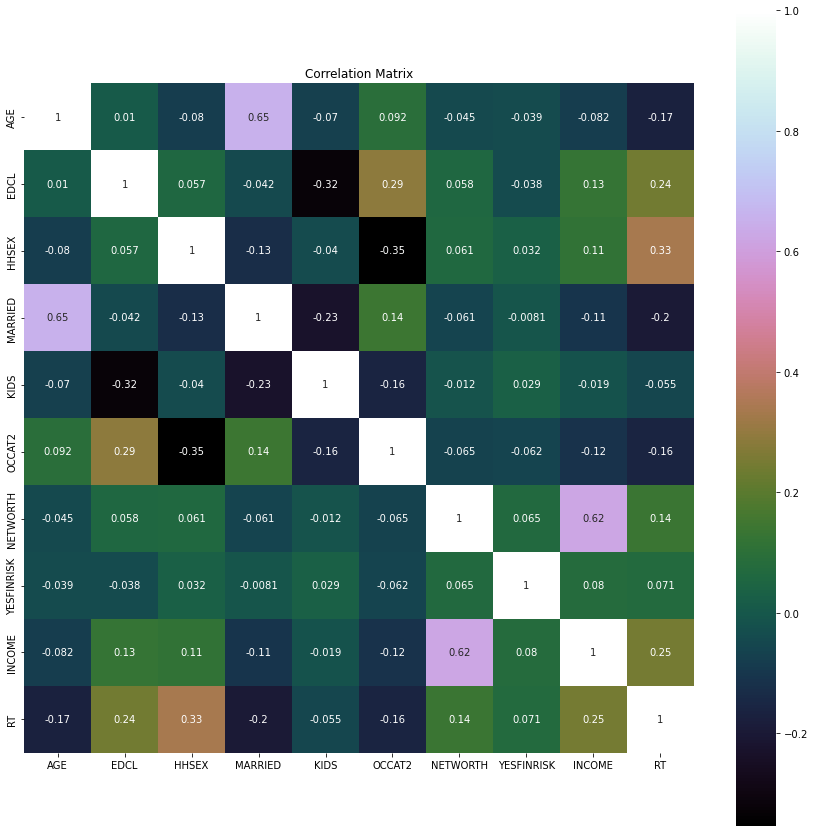

In [29]:
# correlation
correlation = dataset.corr()
plt.figure(figsize=(15,15))
plt.title('Correlation Matrix')
sns.heatmap(correlation, vmax=1, square=True,annot=True,cmap='cubehelix')

<Figure size 1080x1080 with 0 Axes>

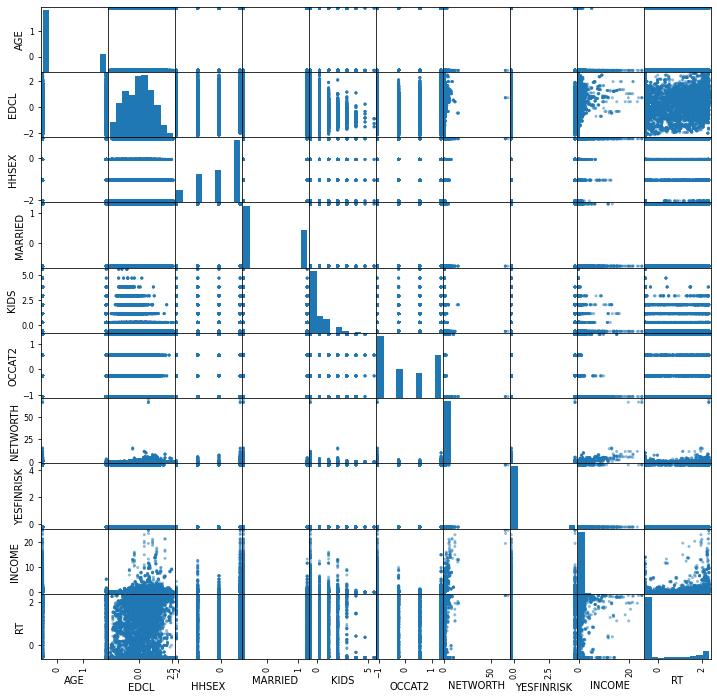

In [30]:
# Scatterplot Matrix
from pandas.plotting import scatter_matrix
plt.figure(figsize=(15,15))
scatter_matrix(dataset,figsize=(12,12))
plt.show()

Looking at the correlation chart above, networth and income are positively correlated with the risk tolerance.
With more number of kids and marriage the risk tolerance decreases. As the willingness to take risk decreases the risk tolerance decreases. With age there is a positive relationship of the risk tolerance. 

As per the paper "Does Risk Tolerance Decrease With Age?(Hui Wang1,Sherman Hanna)", Relative risk aversion decreases as people age (i.e., the proportion of net wealth invested in risky assets increases as people age) when other variables are held constant.Therefore, risk tolerance increases with age. 

So, in summary all the variables and their relationship with risk tolerance seems intuitive.

<a id='4'></a>
# 4. Evaluate Algorithms and Models

In [32]:
# split out validation dataset for the end
Y= dataset["RT"].fillna(0)
X = dataset.loc[:, dataset.columns != 'RT']
# scaler = StandardScaler().fit(X)
# rescaledX = scaler.transform(X)
validation_size = 0.2
seed = 3
X_train, X_validation, Y_train, Y_validation = train_test_split(X, Y, test_size=validation_size, random_state=seed)

<AxesSubplot:xlabel='RT'>

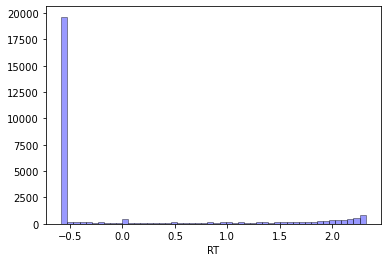

In [33]:
sns.distplot(Y, hist=True, kde=False, color = 'blue',
             hist_kws={'edgecolor':'black'})

In [34]:
Y.describe()

count    2.888500e+04
mean     6.078034e-16
std      9.934525e-01
min     -5.841377e-01
25%     -5.841377e-01
50%     -5.841377e-01
75%      2.741201e-01
max      2.320735e+00
Name: RT, dtype: float64

In [35]:
# test options for regression
num_folds = 10
#scoring = 'neg_mean_squared_error'
#scoring ='neg_mean_absolute_error'
scoring = 'r2'

In [36]:
# spot check the algorithms
models = []
models.append(('LR', LinearRegression()))
models.append(('LASSO', Lasso()))
models.append(('EN', ElasticNet()))
models.append(('KNN', KNeighborsRegressor()))
models.append(('CART', DecisionTreeRegressor()))
#Neural Network
models.append(('MLP', MLPRegressor()))
#Ensable Models 
# Boosting methods
models.append(('ABR', AdaBoostRegressor()))
models.append(('GBR', GradientBoostingRegressor()))
# Bagging methods
models.append(('RFR', RandomForestRegressor()))
models.append(('ETR', ExtraTreesRegressor()))

In [37]:
results = []
names = []
for name, model in models:
    kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
    #converted mean square error to positive. The lower the beter
    cv_results = -1* cross_val_score(model, X_train, Y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

LR: -0.222704 (0.007147)
LASSO: 0.000307 (0.000358)
EN: 0.000307 (0.000358)
KNN: -0.732419 (0.014827)
CART: -0.804457 (0.015268)
MLP: -0.454835 (0.009529)
ABR: -0.363189 (0.023784)
GBR: -0.470507 (0.012339)
RFR: -0.898166 (0.007508)
ETR: -0.960599 (0.005513)


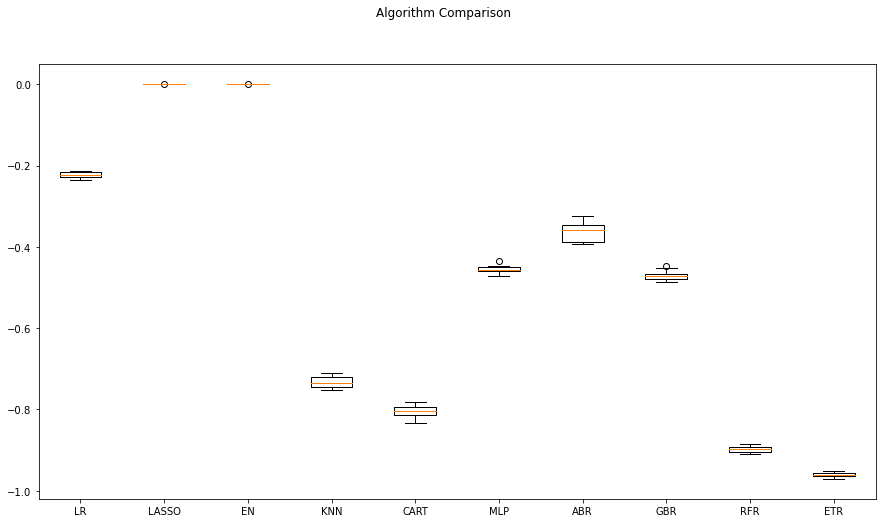

In [38]:
# compare algorithms
fig = plt.figure()
fig.suptitle('Algorithm Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
fig.set_size_inches(15,8)
plt.show()

The non linear models perform better than the linear models, which means that a non linear relationship between the risk tolerance and the difference variables use to predict it. Given extra trees regression is one of the best methods, we use it for further grid search. 

# 5. Model Tuning and Grid Search

In [42]:
param_grid = {'n_estimators': [150,200,250,300]}
model = ExtraTreesRegressor()
kfold = KFold(n_splits=num_folds, random_state=seed, shuffle=True)
grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
grid_result = grid.fit(X_train, Y_train)
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.961356 using {'n_estimators': 300}
0.960928 (0.005069) with: {'n_estimators': 150}
0.961238 (0.005474) with: {'n_estimators': 200}
0.961273 (0.005066) with: {'n_estimators': 250}
0.961356 (0.005178) with: {'n_estimators': 300}


Extra Trees with number of estimators 300, is the best model after grid search. 

<a id='6'></a>
# 6. Finalise the Model

In [43]:
# prepare model
model = ExtraTreesRegressor(n_estimators = 300)
model.fit(X_train, Y_train)

ExtraTreesRegressor(n_estimators=300)

In [44]:
from sklearn.metrics import r2_score
predictions_train = model.predict(X_train)
print(r2_score(Y_train, predictions_train))

0.9999987697707543


In [45]:
# estimate accuracy on validation set
# transform the validation dataset
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
#rescaledValidationX = scaler.transform(X_validation)
predictions = model.predict(X_validation)
print(mean_squared_error(Y_validation, predictions))
print(r2_score(Y_validation, predictions))

0.03180301527430787
0.9672503927342035


From the mean square error and R2 shown above for the test set, the results look good. 

[0.00902112 0.14233276 0.02676732 0.01399695 0.0299439  0.03017666
 0.16323667 0.01038458 0.57414004]


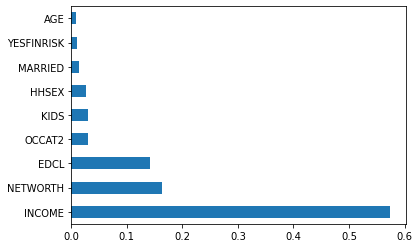

In [46]:
import pandas as pd
import numpy as np
model = RandomForestRegressor(n_estimators= 200,n_jobs=-1)
model.fit(X_train,Y_train)
print(model.feature_importances_) #use inbuilt class feature_importances of tree based classifiers
#plot graph of feature importances for better visualization
feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh')
plt.show()

From the chart above, income and networth followed by age and willingness to take risk are the key variables to decide the risk tolerance. These variables have been considered as the key variables to model the risk tolerance across several literature. 

In [47]:
# Save Model Using Pickle
from pickle import dump
from pickle import load

# save the model to disk
filename = 'risk tolerance_model.sav'
dump(model, open(filename, 'wb'))

In [48]:
# load the model from disk
loaded_model = load(open(filename, 'rb'))
# estimate accuracy on validation set
predictions = loaded_model.predict(X_validation)
result = mean_squared_error(Y_validation, predictions)
print(r2_score(Y_validation, predictions))
print(result)

0.9096174314324276
0.08777015813828495


__Conclusion__:

This case study showed that machine learning models might be able to objectively
analyze the behavior of different investors and attribute these to variables involved in determining risk appetite.

There is a non-linear relationship between the variables and the risk tolerance. Income and net worth followed by educational level and willingness to take risk are the key variables to decide the risk tolerance. These variables have been considered as the key variables to model the risk tolerance across several literature.